In [ ]:
import os
import tarfile
import urllib.request
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# STL-10 데이터셋 다운로드 및 압축 해제
def download_and_extract_stl10(url, dataset_dir):
    if not os.path.exists(dataset_dir):  # 디렉토리 없으면 생성
        os.makedirs(dataset_dir)
    dataset_path = os.path.join(dataset_dir, "stl10_binary.tar.gz")
    if not os.path.exists(dataset_path):  # 데이터셋 없으면 다운로드
        print("Downloading STL-10 dataset...")
        urllib.request.urlretrieve(url, dataset_path)
        print("Download complete.")

    with tarfile.open(dataset_path) as tar:  # 압축 해제
        print("Extracting dataset...")
        tar.extractall(path=dataset_dir)
        print("Extraction complete.")

# STL-10 데이터 로드
def load_stl10(dataset_dir):
    def read_all_images(path):  # 이미지 읽어오기
        with open(path, "rb") as f:
            everything = np.fromfile(f, dtype=np.uint8)
            return everything.reshape(-1, 3, 96, 96).transpose(0, 3, 2, 1)

    def read_labels(path):  # 레이블 읽어오기
        with open(path, "rb") as f:
            return np.fromfile(f, dtype=np.uint8)

    # 학습/테스트 데이터 불러오기
    X_train = read_all_images(os.path.join(dataset_dir, "stl10_binary", "train_X.bin"))
    y_train = read_labels(os.path.join(dataset_dir, "stl10_binary", "train_y.bin"))
    X_test = read_all_images(os.path.join(dataset_dir, "stl10_binary", "test_X.bin"))
    y_test = read_labels(os.path.join(dataset_dir, "stl10_binary", "test_y.bin"))

    return (X_train, y_train), (X_test, y_test)

# 데이터 전처리
def preprocess_data(X, y):
    # 픽셀 값 정규화
    X = X.astype("float32") / 255.0

    # PyTorch 텐서로 변환
    X = torch.tensor(X).permute(0, 3, 1, 2)  # NCHW 형식으로 변환
    y = torch.tensor(y - 1, dtype=torch.long)  # 레이블을 0부터 시작하도록 변경

    return X, y


In [ ]:
# Define MLP model
class MLP(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
dataset_url = "http://ai.stanford.edu/~acoates/stl10/stl10_binary.tar.gz"
dataset_dir = "./stl10_dataset"

# Download and extract the dataset
download_and_extract_stl10(dataset_url, dataset_dir)

Extracting dataset...
Extraction complete.


Epoch 1/20, Train Loss: 2.5158, Train Acc: 0.1785, Val Acc: 0.2280
Epoch 2/20, Train Loss: 1.9312, Train Acc: 0.2760, Val Acc: 0.2460
Epoch 3/20, Train Loss: 1.8383, Train Acc: 0.3157, Val Acc: 0.3340
Epoch 4/20, Train Loss: 1.7648, Train Acc: 0.3427, Val Acc: 0.3040
Epoch 5/20, Train Loss: 1.6957, Train Acc: 0.3760, Val Acc: 0.3290
Epoch 6/20, Train Loss: 1.6379, Train Acc: 0.3925, Val Acc: 0.3530
Epoch 7/20, Train Loss: 1.6217, Train Acc: 0.4027, Val Acc: 0.3560
Epoch 8/20, Train Loss: 1.5779, Train Acc: 0.4120, Val Acc: 0.3680
Epoch 9/20, Train Loss: 1.5315, Train Acc: 0.4323, Val Acc: 0.3600
Epoch 10/20, Train Loss: 1.4878, Train Acc: 0.4517, Val Acc: 0.3840
Epoch 11/20, Train Loss: 1.4380, Train Acc: 0.4660, Val Acc: 0.3620
Epoch 12/20, Train Loss: 1.3876, Train Acc: 0.4923, Val Acc: 0.3500
Epoch 13/20, Train Loss: 1.3621, Train Acc: 0.5030, Val Acc: 0.3530
Epoch 14/20, Train Loss: 1.3354, Train Acc: 0.5132, Val Acc: 0.3830
Epoch 15/20, Train Loss: 1.2299, Train Acc: 0.5553, Val A

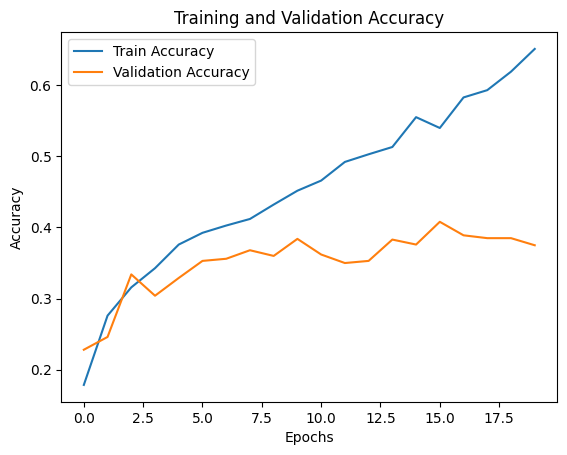

In [ ]:
# 데이터 로드
(X_train, y_train), (X_test, y_test) = load_stl10(dataset_dir)

# 데이터 전처리
X_train, y_train = preprocess_data(X_train, y_train)
X_test, y_test = preprocess_data(X_test, y_test)

# 학습 데이터를 학습/검증 세트로 분할
train_dataset = TensorDataset(X_train, y_train)
val_size = int(0.2 * len(train_dataset))  # 검증 세트 크기 계산
train_size = len(train_dataset) - val_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# 데이터 로더 생성
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=64, shuffle=False)

# 디바이스 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 모델, 손실 함수, 옵티마이저 정의
model = MLP(96 * 96 * 3, 10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습 루프
num_epochs = 20
train_acc, val_acc = [], []
for epoch in range(num_epochs):
    model.train()
    correct, total, train_loss = 0, 0, 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)

    train_acc.append(correct / total)  # 학습 정확도 저장

    # 검증 루프
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)

    val_acc.append(correct / total)  # 검증 정확도 저장

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss / len(train_loader):.4f}, Train Acc: {train_acc[-1]:.4f}, Val Acc: {val_acc[-1]:.4f}")

# 테스트
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)

print(f"Test Accuracy: {correct / total:.4f}")

# 학습 로그 시각화
plt.figure()
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()


# STL-10 데이터셋의 특징점

STL-10 데이터셋도 딥러닝 및 머신러닝 연구에서 자주 사용되는 이미지 데이터셋 이지만, 특히 준지도 학습(semi-supervised learning) 및 전이 학습(transfer learning) 실험에 적합하도록 설계되었다.

# 데이터셋 개요
- **이미지 크기**: 96x96x3 (RGB 컬러 이미지)
- **클래스 수**: 10개 (다음과 같은 클래스 포함)
  - Airplane
  - Bird
  - Car
  - Cat
  - Deer
  - Dog
  - Horse
  - Monkey
  - Ship
  - Truck
- **데이터 분할**:
  - Training Set: 5,000개 (각 클래스당 500개)
  - Test Set: 8,000개 (클래스당 고르게 분포)
  - Unlabeled Set: 100,000개 (라벨 없이 제공됨)

# 주요 특징
1. **저해상도에서 고해상도로 확장**  
   CIFAR-10 데이터셋과 유사하지만 더 큰 이미지(96x96x3)을 포함한다.

2. **준지도 학습 지원**  
   Unlabeled Set이 제공되어, 라벨이 없는 데이터를 활용한 학습 기법을 연구하는 데 이상적입니다.

3. **다양한 데이터 분포**  
   실세계에서 촬영된 이미지를 기반으로 하며, 다양한 조명, 배경, 각도 등의 변형을 포함하여 현실적인 시나리오를 반영합니다.

# 데이터 전처리
STL-10 데이터셋을 사용하기 위해 일반적으로 다음과 같은 전처리 단계를 수행합니다:
1. **정규화**: 각 채널의 평균과 표준편차를 계산하여 픽셀 값을 정규화합니다.
2. **데이터 증강**: 훈련 데이터를 확장하기 위해 다음과 같은 기법을 적용할 수 있습니다:
   - 좌우 반전
   - 랜덤 크롭
   - 밝기/대비 조정
   - 학습 모델 기반의 라벨링

## 활용 사례
- **분류 모델 학습**: CNN(Convolutional Neural Network)을 활용한 기본 이미지 분류 실험.
- **준지도 학습**: Unlabeled Set을 활용하여 학습된 표현의 일반화를 실험.
- **전이 학습**: STL-10 데이터셋으로 사전 학습한 모델을 다른 데이터셋에 적용.


# 라벨링 되지 않은 데이터 활용 방안

라벨링 되지 않은 데이터 10만 장의 활용도가 이 과제에서 매우 중요해보였다. 이러한 데이터를 어떻게 활용할지가 핵심인 것 같다. 그에 대한 방안으로는 아래 두 가지 방식이 떠올랐는데,

- **자가 지도 학습(Self-supervised Learning)**  
  추후 학습할 예정인 자가 지도 학습은 라벨링되지 않은 데이터를 효과적으로 활용할 수 있는 방법 중 하나다. 하지만 현재 자가 지도 학습 방법에 대한 지식이 부족하여 이번 과제에서는 사용하지 않았다.

- **준지도 학습(Semi-supervised Learning)**  
  준지도 학습 역시 라벨링되지 않은 데이터를 활용할 수 있는 방법으로 고려되었다. 용어가 정확한지는 모르겠지만, 일단 train data에 대해서 학습을 하고, 학습한 모델을 바탕으로 labeling 되지 않은 모델들에 대해 학습 모델로 labeling 하는 방법이다. 하지만 실험 결과, 만족스러운 성능을 내지 못해 최종 제출본에서 삭제하였다.  


#특이사항

STL10 데이터셋에 포함된 약 10만 개의 비라벨(unlabeled) 데이터를 활용하고자, Pseudo-Labeling을 적용한 반지도 학습(semi-supervised learning)을 시도해 보았습니다.

Pseudo-Labeling이란, 라벨이 없는 데이터에 대해 현재 모델이 예측한 라벨을 일정 확률 이상 확신할 경우, 이를 '가짜 라벨(pseudo-label)'로 간주하고 마치 지도학습 데이터처럼 추가 학습에 활용하는 기법입니다.

그러나 실험 결과, 지도학습만 단독으로 수행했을 때보다 성능이 크게 향상되지 않았습니다. 이는 기존에 MLP 모델이 학습한 정확도가 낮아서, 비라벨 데이터에 대한 pseudo-label이 잘못 예측된 경우가 많았기 때문이라 추정됩니다. 잘못된 pseudo-label이 반복적으로 학습되면서 모델이 더욱 오분류를 학습했을 가능성이 큽니다.

결론적으로, 반지도학습의 한 방법인 pseudo-labeling과 단순 MLP를 사용하여 STL10을 분류하려 했지만 기대만큼의 성능 향상은 얻지 못하였습니다. 결국 지도학습 모드로 다시 전환하여 실험 시간을 단축하는 방법을 선택했으며, 이를 통해 STL10 같은 복잡한 이미지 분류 문제에는 더 적합한 모델 구조가 필요하다는 점을 확인할 수 있었습니다.

# 분석 및 고찰

입력 데이터의 구조적 또는 공간적 정보를 고려하지 못하며, **모든 입력을 단순히 하나의 벡터로 취급**합니다. 따라서, **이미지 데이터의 공간적 관계를 학습하는 데 비효율적**입니다. 또한, 많은 파라미터 수로 인해 고차원 데이터나 대규모 데이터셋에 대한 학습이 어렵고, **오버피팅 위험**이 있습니다.
Horizontal Flip과 Vertical Flip을 적용한 **데이터 증강**은 모델 학습 데이터의 다양성을 증가시키는 데 기여했으나, **MLP의 구조적 한계**로 인해 성능 향상으로 이어지지 못했습니다. MLP는 이미지의 공간적 특성을 활용하지 못하므로, 이미지 데이터 처리에는 적합하지 않은 모델로 볼 수 있습니다.